In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset =  torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship   cat  frog truck


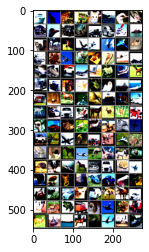

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:

import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self, dropout_rate):

        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=5, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )

        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)  
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), 
            #nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.Dropout(dropout_rate)
        )

        self.transblock2 = nn.Sequential(
            nn.MaxPool2d(2, 2),  
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,dilation=2)  
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            # Depthwise separable convolution
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=32, padding=1),  
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3)
        )

        self.transblock3 = nn.Sequential(
            nn.MaxPool2d(2, 2),  
            #nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)  
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate),

            
            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  
            #nn.ReLU(),
            #nn.BatchNorm2d(64),
            #nn.Dropout(dropout_rate)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  

        self.fc = nn.Sequential(
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        """ This function defines the network structure """

        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)  + x
        x = self.transblock2(x)
        x = self.convblock3(x)  + x
        x = self.transblock3(x) 
        x = self.convblock4(x)  
        x = self.gap(x)
        x = x.view(-1, 64)
        x = self.fc(x)
        return x


net = Net(0.1)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
!pip install torchsummary
from torchsummary import summary

model = net.to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             280
              ReLU-2           [-1, 10, 32, 32]               0
       BatchNorm2d-3           [-1, 10, 32, 32]              20
           Dropout-4           [-1, 10, 32, 32]               0
            Conv2d-5           [-1, 16, 30, 30]           4,016
              ReLU-6           [-1, 16, 30, 30]               0
       BatchNorm2d-7           [-1, 16, 30, 30]              32
           Dropout-8           [-1, 16, 30, 30]               0
         MaxPool2d-9           [-1, 16, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]             544
           Conv2d-11           [-1, 32, 15, 15]           9,248
             ReLU-12           [-1, 32, 15, 15]               0
      BatchNorm2d-13           [-1, 32, 15, 15]              64
          Dropout-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train and Test functions

In [9]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

#model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=15,steps_per_epoch=len(trainloader))


for epoch in range(0, 50):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if(epoch==25):
      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

    if(epoch==40):
      optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0


loss=1.0697747468948364 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]


Train set: Average loss: 0.0121, Accuracy: 21240/50000 (42.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.7974, Accuracy: 5696/10000 (56.96%)

Epoch 1


loss=1.1315460205078125 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.56it/s]


Train set: Average loss: 0.0093, Accuracy: 28635/50000 (57.27%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.2708, Accuracy: 6103/10000 (61.03%)

Epoch 2


loss=0.9257819056510925 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.70it/s]


Train set: Average loss: 0.0083, Accuracy: 30986/50000 (61.97%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.5638, Accuracy: 6472/10000 (64.72%)

Epoch 3


loss=0.8535516858100891 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.62it/s]


Train set: Average loss: 0.0077, Accuracy: 32533/50000 (65.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.0459, Accuracy: 6715/10000 (67.15%)

Epoch 4


loss=1.1469848155975342 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]


Train set: Average loss: 0.0072, Accuracy: 33668/50000 (67.34%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5638, Accuracy: 7049/10000 (70.49%)

Epoch 5


loss=0.8581643104553223 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


Train set: Average loss: 0.0068, Accuracy: 34572/50000 (69.14%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5711, Accuracy: 7254/10000 (72.54%)

Epoch 6


loss=0.7936787605285645 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.05it/s]


Train set: Average loss: 0.0066, Accuracy: 35230/50000 (70.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.0240, Accuracy: 7378/10000 (73.78%)

Epoch 7


loss=0.6617342233657837 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]


Train set: Average loss: 0.0063, Accuracy: 35843/50000 (71.69%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1890, Accuracy: 7423/10000 (74.23%)

Epoch 8


loss=0.8867731094360352 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]



Train set: Average loss: 0.0062, Accuracy: 36060/50000 (72.12%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.2176, Accuracy: 7445/10000 (74.45%)

Epoch 9


loss=0.7595213651657104 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.70it/s]


Train set: Average loss: 0.0060, Accuracy: 36550/50000 (73.10%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3373, Accuracy: 7600/10000 (76.00%)

Epoch 10


loss=0.7405089735984802 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]


Train set: Average loss: 0.0059, Accuracy: 36899/50000 (73.80%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.5345, Accuracy: 7560/10000 (75.60%)

Epoch 11


loss=0.7639174461364746 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]


Train set: Average loss: 0.0057, Accuracy: 37164/50000 (74.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.2179, Accuracy: 7495/10000 (74.95%)

Epoch 12


loss=0.6819518208503723 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.56it/s]


Train set: Average loss: 0.0056, Accuracy: 37364/50000 (74.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6532, Accuracy: 7750/10000 (77.50%)

Epoch 13


loss=0.865119457244873 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.56it/s]


Train set: Average loss: 0.0055, Accuracy: 37518/50000 (75.04%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8746, Accuracy: 7620/10000 (76.20%)

Epoch 14


loss=0.6207321882247925 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


Train set: Average loss: 0.0054, Accuracy: 37851/50000 (75.70%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9410, Accuracy: 7686/10000 (76.86%)

Epoch 15


loss=0.9043745994567871 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]


Train set: Average loss: 0.0054, Accuracy: 37899/50000 (75.80%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8053, Accuracy: 7823/10000 (78.23%)

Epoch 16


loss=0.8370454907417297 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.65it/s]


Train set: Average loss: 0.0053, Accuracy: 38112/50000 (76.22%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7708, Accuracy: 7809/10000 (78.09%)

Epoch 17


loss=0.8231121897697449 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s]


Train set: Average loss: 0.0053, Accuracy: 38254/50000 (76.51%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8315, Accuracy: 7803/10000 (78.03%)

Epoch 18


loss=0.6856508851051331 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


Train set: Average loss: 0.0052, Accuracy: 38228/50000 (76.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8614, Accuracy: 7883/10000 (78.83%)

Epoch 19


loss=0.5121853351593018 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]


Train set: Average loss: 0.0051, Accuracy: 38465/50000 (76.93%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1984, Accuracy: 7930/10000 (79.30%)

Epoch 20


loss=0.7510268092155457 batch_id=109:  28%|██▊       | 110/391 [00:04<00:11, 24.76it/s]

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

